In [2]:
# coding: utf-8
import numpy as np
import scipy.misc
import scipy.io
import scipy
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.color
%matplotlib inline

In [3]:
def net(image):  ### 输入的图像不用normalization [batch, height = 256, width = 256, channel = 3]
    normalization = batch_norm(image, train=True)
    conv1_1_relu = conv_layer(normalization, 64, 3, 1, relu=True) #[batch, height = 256, width = 256, channel = 64]
    conv1_2_relu = conv_layer(conv1_1_relu, 64, 3, 1, relu=True)
    conv1_2norm = batch_norm(conv1_2_relu, train=True)

    conv2_1_relu = conv_layer(conv1_2norm, 128, 3, 1, relu=True)
    conv2_2_relu = conv_layer(conv1_1_relu, 128, 3, 2, relu=True) # 
    conv2_2norm = batch_norm(conv2_2_relu, train=True)


    conv3_1_relu = conv_layer(conv2_2norm, 256, 3, 1, relu=True)
    conv3_2_relu = conv_layer(conv3_1_relu, 256, 3, 1, relu=True)
    conv3_3_relu = conv_layer(conv3_2_relu, 256, 3, 2, relu=True)
    conv3_3norm = batch_norm(conv3_3_relu, train=True)
    '''
    conv4_1 (Stride:1,pad:1 dilation: 1)> relu4_1 > conv4_2(same) > relu4_2 > conv4_3(same) > relu4_3 > conv4_3_norm

    tf.nn.atrous_conv2d(net, weights_init, rate, 'SAME')
    conv_layer_dila(net, num_filters, filter_size, rate, relu=True)
    '''
    conv4_1_relu = conv_layer(conv3_3norm, 512, 3, 2, relu=True)
    conv4_2_relu = conv_layer_dila(conv4_1_relu, 512, 3, 1, relu=True)
    conv4_3_relu = conv_layer_dila(conv4_2_relu, 512, 3, 1, relu=True)
    conv4_3norm = batch_norm(conv4_3_relu, train=True)



    '''

    conv8_1(256, kernal:4 stride:2 pad:1 dilation:1) > relu8_1 > conv8_2(kernal:3 stride:1) > relu8_2 > conv8_3

    '''
    conv8_1_relu = conv_tranpose_layer(conv4_3norm, 256, 4, 2)
    conv8_2_relu = conv_layer(conv8_1_relu, 256, 3, 1, relu=True)
    conv8_3_relu = conv_layer(conv8_2_relu, 256, 3, 1, relu=True)
    
    
    conv9_1 = conv_layer(conv8_3_relu, 128, 3, 1, relu=True)
    conv9_2 = conv_layer(conv9_1, 64, 3, 2, relu=True)
    conv9_3 = conv_layer(conv9_2, 32, 3, 2, relu=True)
    conv9_4 = conv_layer(conv9_3, 3, 3, 1, relu=True)
    

    return conv9_4

In [4]:
def nearest_search(image, palette):
    '''
    Palette shape: (16, 16, 3)
    
    '''
    img_shape = image.shape
    height = img_shape[0] 
    width = img_shape[1] 
    new_img = np.zeros(img_shape)
    for i in range(height):
        for j in range(width):
            index = find_min_idx(np.sum((palette - image[i, j, :])**2,2)) ### Bugs
            new_img[i, j, :] = palette[index[0], index[1], :]
            
    return new_img
            

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return np.int(k/ncol), k%ncol


def get_img(img_path):
    img = scipy.misc.imread(img_path, mode = 'RGB')
    return img

def rgb2lab(image):
    '''
    L range: 0 ~ 100
    a range: -128 ~ 127
    b range: -128 ~ 127
    
    '''
    lab_color = skimage.color.rgb2lab(image)
    return lab_color


def lab2rgb(image):
    rgb_color = skimage.color.lab2rgb(image)
    return rgb_color


In [5]:
def conv_init_vars(net, out_channels, filter_size, transpose=False):
    '''
    
    According to the previous output, intialize the weight matrix.
    
    
    '''
    _, rows, cols, in_channels = [i.value for i in net.get_shape()] ### Obtain in_channels
    
    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]
    
    # weights shape = [Kernal size, kernal size, output kernal, input kernal]

    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev = 0.1, seed=1), dtype=tf.float32)
    
    return weights_init



def batch_norm(net, train=True):
    '''
    
    Apply Batch Normalization Function
    
    BN: Forward norm and then inverse norm.
    
    '''
    batch, rows, cols, channels = [i.value for i in net.get_shape()]### Shape Meaning: [batchsize, height, width, kernels]
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True) ### Calculate the mean and variance of x.Output: One-dimension
    shift = tf.Variable(tf.zeros(var_shape)) ### Inverse Norm
    scale = tf.Variable(tf.ones(var_shape)) ### Inverse Norm
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift ### Applied Batch Normalization


def conv_layer(net, num_filters, filter_size, strides, relu=True):
    '''
    
    Apply convolution operation
    
    '''
    weights_init = conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]                
    net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME')
    
    if relu:
        net = tf.nn.relu(net)   
    
    return net        

def conv_layer_dila(net, num_filters, filter_size, rate, relu=True):
    '''
    
    Apply dilation convolution operation
    
    '''
    weights_init = conv_init_vars(net, num_filters, filter_size)
    #strides_shape = [1, strides, strides, 1]
    
    net = tf.nn.atrous_conv2d(net, weights_init, rate, 'SAME') # Dialation Convolution
                 
    
    if relu:
        net = tf.nn.relu(net)   
    
    return net   

def conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = conv_init_vars(net, num_filters, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i.value for i in net.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)
    # new_shape = #tf.pack([tf.shape(net)[0], new_rows, new_cols, num_filters])
    new_shape = [batch_size, new_rows, new_cols, num_filters]  
    tf_shape = tf.stack(new_shape)   
    strides_shape = [1,strides,strides,1]
    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    return tf.nn.relu(net)



In [7]:
'''

Img loading


'''

tf.reset_default_graph()

img_path = 'C:\\Users\\Orion_Peng\\Pictures\\Saved Pictures\\shuimo_b.jpg'

img = get_img(img_path)

img_resize = scipy.misc.imresize(img, (256, 256)) #Input image

img_resize_lab = rgb2lab(img_resize)

input_img = np.array([img_resize_lab]) ### Batch 

input_img = tf.cast(input_img, tf.float32) ### Transform into tensor

palette = net(input_img)

print(palette)

palette  = tf.reshape(palette, [256, 1, 3])

palette 

Tensor("Relu_16:0", shape=(1, 16, 16, 3), dtype=float32)


<tf.Tensor 'Reshape:0' shape=(256, 1, 3) dtype=float32>

In [8]:
'''

单独跑network要6秒

'''

start_time = datetime.datetime.now()  # 

### How to define the loss ??
img_resize_2 = scipy.misc.imresize(img, (256, 256))

resize_float32 = img_resize_2.astype(np.float32)

resize_float32_ = tf.cast(resize_float32, tf.float32) ### A constant

new_img = tf.Variable(resize_float32_, tf.float32)

loss = tf.reshape(tf.reduce_sum((palette[0, 0, :] - resize_float32_)**2, 2), [256, 256, 1]) 

for i in range(1,256):
    loss_ = tf.reshape(tf.reduce_sum((palette[i, 0, :] - resize_float32_)**2, 2), [256, 256, 1]) 

    loss = tf.concat([loss, loss_], axis = 2)
    
index = tf.argmin(loss, axis = 2) # No gradient defined for operation 'ArgMin' (op type: ArgMin)

grad = tf.gradients(index, input_img)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_palette = palette.eval()
    output_index = index.eval()
    
    for i in range(256):
        for j in range(256):
            resize_float32[i, j, :] = output_palette[output_index[i,j], 0, :]

    final_result = tf.assign(new_img, resize_float32).eval()
    print(sess.run(grad))
    
    tf.get_default_graph().finalize()
end_time = datetime.datetime.now() 
print((end_time - start_time).seconds)

LookupError: No gradient defined for operation 'ArgMin' (op type: ArgMin)

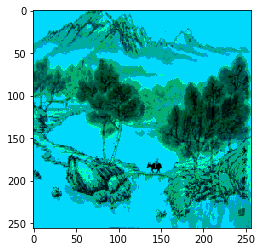

In [82]:
plt.imshow(final_result.astype(np.uint8))

In [74]:
from collections import Counter

np.unique(np.sum(final_result.astype(np.uint8), 2))

array([  0,   1,   2,   4,   6,   7,  11,  15,  18,  21,  23,  37,  41,
        55,  63,  82,  89,  93, 105, 114, 130, 138, 140, 157, 158, 165,
       170, 176, 180, 199, 201, 202, 216, 224, 235, 268, 291, 301, 302,
       330, 381, 435, 469], dtype=uint32)